In [65]:
import numpy as np
import decimal
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout, Conv1D,MaxPooling1D,Flatten
from decimal import getcontext
import matplotlib.pyplot as plt

getcontext().Emax = 600000000000
import import_ipynb
from Utils import *
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 30
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

In [66]:
""" Il s'agit de modeliser le canal de transmission par une matrice complex."""
N_bits = Mr * np.log2(M)
x_gd = np.zeros((Mt, 1))
gdx1 = np.zeros((Mt, Niter))
d = np.zeros((Mt, 1))
S = np.zeros((1000000, 20))
X = np.zeros((1000000, 200))
H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
HR = H.flatten()
realh = np.real(HR)
imagh = np.imag(HR)
Hr = np.concatenate((realh, imagh), axis=0)
Hr = np.reshape(Hr, (2000, 1)).T
HH = Hr
HH.tolist()
"""Il s'agit de génerer pour chaque H; 100000 symboles émis S et 100000 symboles précodés X.
   C'est l'algorithme de Gradient descente qui permet de minimiser l’erreur quadratique moyenne (MSE) entre les symboles prévus S et les sorties de PA passant par le canal H
   Dans laquelle nous estimons x en minimisant la fonction de coût J (x) par rapport à x et estimons le vecteur de distorsion à travers le chemin de rétroaction. 
   Ainsi, dans la (l + 1) -ième itération, peut être exprimée comme x(l+1) = x(l) −Δx(l) avec Δx(l) = λ∇xJ(x(l),d(l)). """
for j in range(1000000):
    bits = np.random.randint(2, size=int(N_bits))  
    QAM16 = QAMModem(16)  
    z = QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10))
    reals = np.real(Z)
    imags = np.imag(Z)
    s = np.concatenate((reals, imags), axis=1)
    S[j] = s
    for i in range(Niter):
        gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d)- Z.T)
        x_gd = x_gd - mu1 * gdx1
        realx = np.real(x_gd)
        imagx = np.imag(x_gd)
        x_z = np.concatenate((realx, imagx), axis=0).reshape((200))
        X[j] = x_z
        val_IBO_m1dB = (((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G))
        coeff_IBO_m1dB = (val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10)))  
        vin2 = coeff_IBO_m1dB * x_gd
        vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B) 
        K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
        d = vout2 - K0 * vin2  
        y_gd =vout2 / coeff_IBO_m1dB
    MSEgd=np.mean(np.abs((H.dot(y_gd)) - Z.T) ** 2) / (np.mean(np.abs(Z) ** 2))
NMSEGD = 10 * np.log10(np.mean(MSEgd))
print('nmsede GD',NMSEGD)
"Base d'apprentissage"
X_train = S[:900000, :]
y_train = X[:900000, :]
"Base de test"
X_test = S[900000:, :]
y_test = X[900000:, :]

nmsede GD -38.887067640106935


Epoch 1/100
90/90 [==============================] - 1s 15ms/step - loss: 0.0272 - mse: 0.0025 - val_loss: 0.0106 - val_mse: 2.2582e-04
Epoch 2/100
90/90 [==============================] - 1s 15ms/step - loss: 0.0062 - mse: 1.0685e-04 - val_loss: 0.0015 - val_mse: 8.2596e-06
Epoch 3/100
90/90 [==============================] - 1s 15ms/step - loss: 8.9332e-04 - mse: 1.7980e-06 - val_loss: 7.9345e-04 - val_mse: 1.0507e-06
Epoch 4/100
90/90 [==============================] - 1s 15ms/step - loss: 8.0212e-04 - mse: 1.0691e-06 - val_loss: 7.9565e-04 - val_mse: 1.0488e-06
Epoch 5/100
90/90 [==============================] - 1s 15ms/step - loss: 8.0238e-04 - mse: 1.0685e-06 - val_loss: 7.9910e-04 - val_mse: 1.0578e-06
Epoch 6/100
90/90 [==============================] - 1s 15ms/step - loss: 8.0149e-04 - mse: 1.0659e-06 - val_loss: 8.0119e-04 - val_mse: 1.0616e-06
Epoch 7/100
90/90 [==============================] - 1s 15ms/step - loss: 7.9788e-04 - mse: 1.0565e-06 - val_loss: 7.9992e-04 - val_

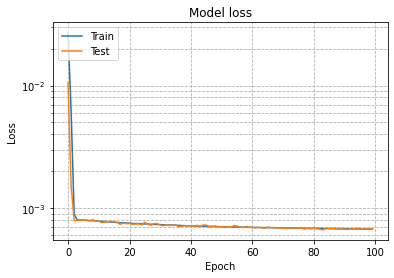

In [153]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1],1))
in_shape=(20,1)
model=Sequential()
model.add(Conv1D(5, 17, activation='linear', input_shape=in_shape)) 
model.add(Flatten())
model.add(Dense(units=200, activation="linear"))
"""
model = Sequential()
model.add(
    Dense(units=20, kernel_initializer="uniform", activation="linear", input_dim=20))"""

model.add(
    Dense(units=200, kernel_initializer="uniform", activation="linear"))
model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=10000,
    epochs=100,
    shuffle=True,
)

# Loss representation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()
# Make predictions
y_pred = model.predict(X_train)
y_predt = model.predict(X_test)



In [154]:
NMSE_calcul(X_test.reshape((100000,20)),y_predt,p,q,G,A,B,Vsat,IBO,H)

-32.76514437750369